# Evaluación de segmentadores para frutas

## 1. Introducción y objetivos

En este cuaderno desarrollamos un conjunto de segmentadores para frutas (manzana, banana y naranja) y comparamos su rendimiento frente a máscaras *ground truth* derivadas del dataset COCO. También se incluyen visualizaciones de los resultados y un panel interactivo para elegir la fruta y el método de segmentación.

### Objetivos técnicos

1. **Implementar segmentadores basados en color y superpixeles**: Desarrollamos dos métodos propios que aprovechan características de bajo nivel (color HSV y agrupamiento de superpixeles) para segmentar frutas sin requerir modelos de aprendizaje profundo.

2. **Comparar con modelo de deep learning**: Utilizamos Mask R-CNN pre-entrenado como línea base para evaluar el rendimiento de nuestros métodos frente a técnicas de estado del arte.

3. **Evaluación cuantitativa**: Calculamos métricas estándar (IoU, Dice, Precisión, Recall) para comparar objetivamente los métodos en términos de exactitud y eficiencia computacional.

> **Instrucciones para exportar**: antes de entregar, ejecute todas las celdas en orden y utilice `Archivo → Imprimir → Guardar como PDF` o `nbconvert` para generar el informe.

> **Nota**: si ya descargaste el zip de anotaciones anteriormente, puedes omitir la descarga estableciendo `SKIP_DOWNLOAD = True` en la celda siguiente.



## 2. Preparación: librerías y conjunto de datos

En esta sección instalamos dependencias, descargamos un subconjunto de COCO 2017 con frutas específicas y construimos las máscaras *ground truth* que usaremos para entrenar y evaluar los segmentadores.

### Descripción técnica del proceso

**Estructura de datos COCO**: El dataset COCO (Common Objects in Context) proporciona anotaciones en formato JSON que incluyen:
- Metadatos de imágenes (dimensiones, nombre de archivo, ID)
- Anotaciones de segmentación en formato RLE (Run-Length Encoding) para cada instancia de objeto
- Categorías con IDs numéricos (apple=53, banana=52, orange=55)

**Pipeline de preparación**:
1. **Descarga de anotaciones**: Se obtiene el archivo `instances_val2017.json` que contiene todas las anotaciones de segmentación del conjunto de validación.
2. **Selección de imágenes**: Se filtran imágenes que contengan al menos una de las tres frutas objetivo, usando un muestreo aleatorio con semilla fija (42) para reproducibilidad.
3. **Descarga de imágenes**: Se obtienen las imágenes originales desde el servidor de COCO.
4. **Generación de máscaras ground truth**: Se decodifican las anotaciones RLE y se agrupan por categoría en un tensor 3D `(n_categorías, altura, ancho)` donde cada canal binario representa la presencia de una fruta específica.



In [1]:
# Instalación de dependencias (ejecutar sólo una vez por entorno)
# 
# Descripción técnica de las dependencias:
# - numpy: Operaciones numéricas eficientes sobre arrays multidimensionales
# - matplotlib: Visualización de imágenes y gráficos
# - pillow (PIL): Manipulación de imágenes (carga, conversión de formatos)
# - scikit-image: Algoritmos de procesamiento de imágenes (SLIC, morfología)
# - opencv-python: Operaciones de visión por computadora (conversión de espacios de color)
# - ipywidgets: Widgets interactivos para Jupyter
# - pandas: Manipulación y análisis de datos estructurados (DataFrames)
# - tqdm: Barras de progreso para loops
# - torch, torchvision: PyTorch y modelos pre-entrenados (Mask R-CNN)
# - pycocotools: Herramientas para trabajar con el formato COCO (decodificación RLE)

import sys
import subprocess

packages = [
    "numpy",
    "matplotlib",
    "pillow",
    "scikit-image",
    "opencv-python",
    "ipywidgets",
    "pandas",
    "tqdm",
    "torch",
    "torchvision",
    "pycocotools"
]

for pkg in packages:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg])

print("Dependencias instaladas.")



Dependencias instaladas.


In [2]:
# Preparación de estructura de directorios y descarga de anotaciones COCO
#
# Funcionamiento técnico:
# 1. Se crea una estructura de directorios jerárquica para organizar:
#    - images/: Imágenes originales descargadas de COCO
#    - masks/: Máscaras ground truth generadas (formato .npz comprimido)
#    - annotations/: Archivos JSON con metadatos y anotaciones COCO
#
# 2. Descarga condicional: Solo se descarga el ZIP si no existe y SKIP_DOWNLOAD=False
#    El archivo annotations_trainval2017.zip contiene ~241MB de anotaciones
#
# 3. Extracción: Se descomprime el ZIP solo si el directorio annotations/ no existe
#    El archivo instances_val2017.json contiene ~815K instancias de objetos

import json
import os
from pathlib import Path
from urllib.request import urlretrieve

from pycocotools.coco import COCO
from tqdm import tqdm

DATA_DIR = Path("data/coco_frutas")
IMAGES_DIR = DATA_DIR / "images"
MASKS_DIR = DATA_DIR / "masks"
ANNOTATIONS_DIR = DATA_DIR / "annotations"

for d in (IMAGES_DIR, MASKS_DIR, ANNOTATIONS_DIR):
    d.mkdir(parents=True, exist_ok=True)

ANNOTATION_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
ANNOTATION_ZIP = ANNOTATIONS_DIR / "annotations_trainval2017.zip"
SKIP_DOWNLOAD = False  # Cambia a True si ya tienes las anotaciones extraídas.

if not (ANNOTATIONS_DIR / "annotations" / "instances_val2017.json").exists():
    if not ANNOTATION_ZIP.exists() and not SKIP_DOWNLOAD:
        print("Descargando anotaciones COCO (puede tardar unos minutos)...")
        urlretrieve(ANNOTATION_URL, ANNOTATION_ZIP)
    if not (ANNOTATIONS_DIR / "annotations").exists():
        import zipfile
        print("Extrayendo anotaciones...")
        with zipfile.ZipFile(ANNOTATION_ZIP, 'r') as zip_ref:
            zip_ref.extractall(ANNOTATIONS_DIR)

print("Preparación de directorios completada.")



Descargando anotaciones COCO (puede tardar unos minutos)...
Extrayendo anotaciones...
Preparación de directorios completada.


In [3]:
# Selección de subconjunto de imágenes con frutas objetivo
#
# Algoritmo de selección:
# 1. Carga el objeto COCO que indexa todas las anotaciones del conjunto de validación
# 2. Para cada categoría de fruta (apple=53, banana=52, orange=55):
#    - Obtiene todos los IDs de imágenes que contienen esa categoría
#    - Aplica muestreo aleatorio con semilla fija (42) para reproducibilidad
#    - Selecciona máximo 25 imágenes por categoría (o todas si hay menos)
# 3. Usa un set() para eliminar duplicados (imágenes que contienen múltiples frutas)
# 4. Carga los metadatos completos de las imágenes seleccionadas
#
# Resultado: Un subconjunto balanceado y reproducible de ~68 imágenes que contiene
# al menos una instancia de manzana, banana o naranja.

import random

VAL_ANNOTATIONS = ANNOTATIONS_DIR / "annotations" / "instances_val2017.json"
assert VAL_ANNOTATIONS.exists(), "No se encontró el archivo de anotaciones, ejecuta la celda anterior."

coco = COCO(str(VAL_ANNOTATIONS))
FRUIT_CATEGORIES = {
    "apple": 53,
    "banana": 52,
    "orange": 55,
}

image_ids = set()
for cat_name, cat_id in FRUIT_CATEGORIES.items():
    cat_img_ids = coco.getImgIds(catIds=[cat_id])
    random.seed(42)
    random_subset = random.sample(cat_img_ids, min(25, len(cat_img_ids)))
    image_ids.update(random_subset)

image_data = coco.loadImgs(list(image_ids))
print(f"Total de imágenes seleccionadas: {len(image_data)}")



loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Total de imágenes seleccionadas: 68


In [4]:
# Descarga de imágenes y generación de máscaras ground truth
#
# FASE 1: Descarga de imágenes
# - Descarga condicional: Solo descarga si el archivo no existe localmente
# - Formato: Imágenes JPEG desde el servidor oficial de COCO
# - Estructura: Cada imagen mantiene su nombre original (ej: 000000006614.jpg)
#
# FASE 2: Generación de máscaras (proceso crítico)
# Para cada imagen:
# 1. Inicializa un tensor 3D: (n_categorías=3, altura, ancho) con ceros
# 2. Obtiene todas las anotaciones de segmentación para esa imagen y categorías objetivo
# 3. Para cada anotación:
#    - Convierte la segmentación a formato RLE (Run-Length Encoding)
#    - Decodifica RLE a máscara binaria 2D usando coco_mask.decode()
#    - Identifica el índice de categoría (0=apple, 1=banana, 2=orange)
#    - Acumula la máscara en el canal correspondiente usando np.maximum() para manejar
#      múltiples instancias de la misma fruta (ej: varias manzanas en una imagen)
# 4. Guarda el tensor completo en formato .npz comprimido para eficiencia de almacenamiento
#
# Nota técnica: np.maximum() permite que si hay múltiples instancias de la misma fruta,
# todas se combinen en un solo canal binario (OR lógico a nivel de píxel).

from pycocotools import mask as coco_mask
import numpy as np
from PIL import Image

IMAGE_BASE_URL = "http://images.cocodataset.org/val2017/"

for img in tqdm(image_data, desc="Descargando imágenes"):
    img_path = IMAGES_DIR / img["file_name"]
    if not img_path.exists():
        urlretrieve(IMAGE_BASE_URL + img["file_name"], img_path)

print("Imágenes descargadas.")

for img in tqdm(image_data, desc="Generando máscaras"):
    img_id = img["id"]
    h, w = img["height"], img["width"]
    mask_stack = np.zeros((len(FRUIT_CATEGORIES), h, w), dtype=np.uint8)
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id], catIds=list(FRUIT_CATEGORIES.values())))
    for ann in annotations:
        cat_id = ann["category_id"]
        cat_index = list(FRUIT_CATEGORIES.values()).index(cat_id)
        segm = ann.get("segmentation", None)
        if segm:
            rle = coco.annToRLE(ann)
            m = coco_mask.decode(rle)
            mask_stack[cat_index] = np.maximum(mask_stack[cat_index], m.astype(np.uint8))
    mask_path = MASKS_DIR / (Path(img["file_name"]).stem + ".npz")
    np.savez_compressed(mask_path, mask=mask_stack)

print("Máscaras generadas.")



Descargando imágenes: 100%|██████████| 68/68 [00:29<00:00,  2.27it/s]


Imágenes descargadas.


Generando máscaras: 100%|██████████| 68/68 [00:00<00:00, 157.79it/s]

Máscaras generadas.


## 3. Exploración del subconjunto

Construimos un pequeño resumen del dataset y visualizamos ejemplos con sus máscaras para entender los retos de segmentación (oclusiones, iluminación, etc.).

### Análisis exploratorio de datos

**Objetivo**: Caracterizar el conjunto de datos antes de entrenar los segmentadores para identificar:
- Distribución de frutas por imagen (cuántas instancias de cada tipo)
- Variabilidad en dimensiones de imágenes
- Retos visuales: oclusiones parciales, variaciones de iluminación, fondos complejos

**Métricas calculadas**:
- Conteo de instancias por categoría por imagen
- Dimensiones (ancho x alto) de cada imagen
- Visualización de ejemplos aleatorios con máscaras superpuestas para inspección cualitativa



In [5]:
import pandas as pd

rows = []
for img in image_data:
    ann_ids = coco.getAnnIds(imgIds=[img["id"]], catIds=list(FRUIT_CATEGORIES.values()))
    anns = coco.loadAnns(ann_ids)
    fruit_counts = {name: 0 for name in FRUIT_CATEGORIES}
    for ann in anns:
        for name, cat_id in FRUIT_CATEGORIES.items():
            if ann["category_id"] == cat_id:
                fruit_counts[name] += 1
    rows.append({
        "file_name": img["file_name"],
        "width": img["width"],
        "height": img["height"],
        **fruit_counts
    })

df = pd.DataFrame(rows)
df.head()



,file_name,width,height,apple,banana,orange
0,000000405249.jpg,500,375,4,0,0
1,000000030213.jpg,640,449,5,0,0
2,000000193926.jpg,640,477,2,4,1
3,000000322959.jpg,612,612,1,2,1
4,000000371472.jpg,480,640,0,11,0


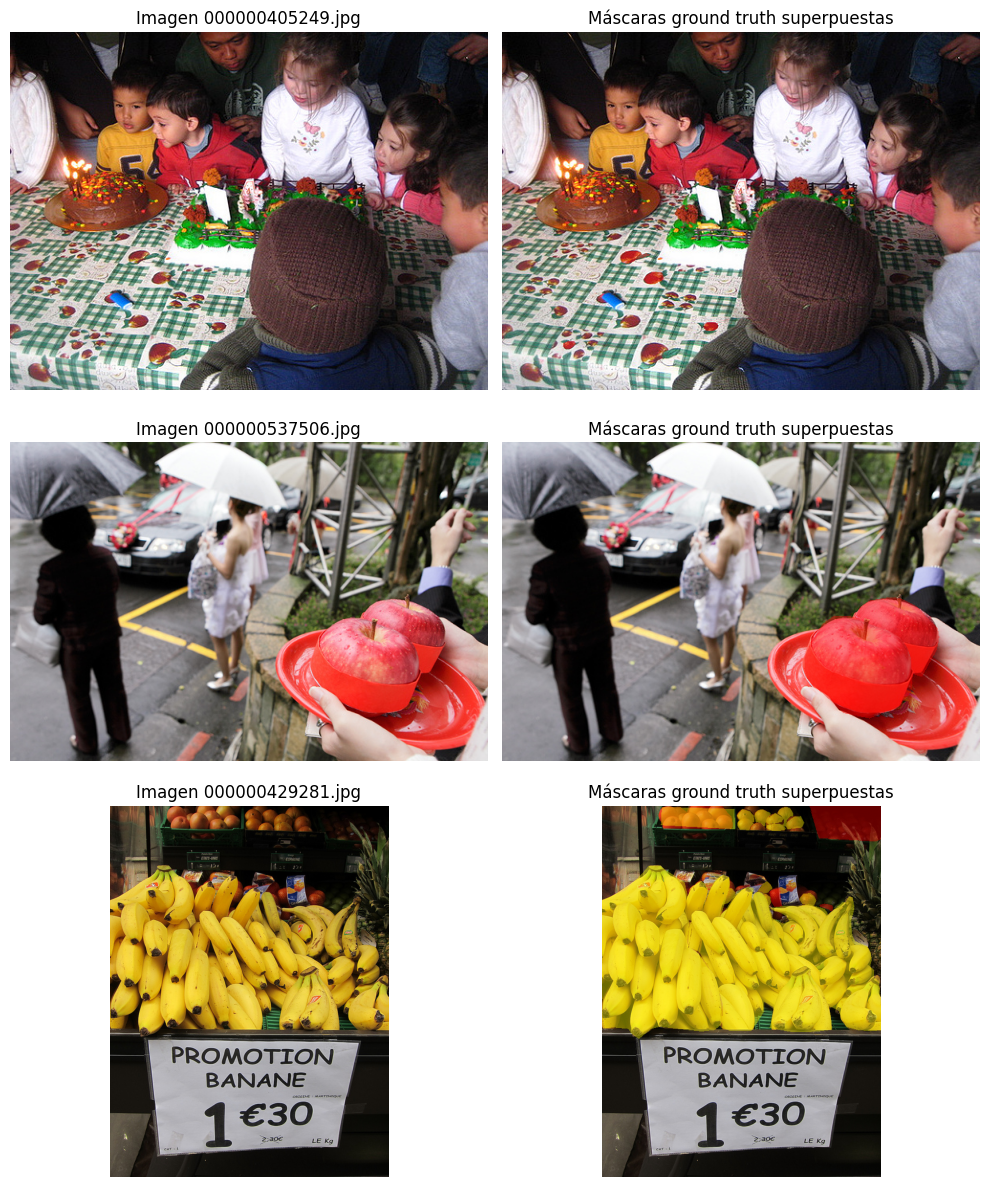

In [6]:
import matplotlib.pyplot as plt
import numpy as np

COLORS = {
    "apple": (1.0, 0, 0, 0.4),
    "banana": (1.0, 1.0, 0, 0.4),
    "orange": (1.0, 0.5, 0, 0.4),
}

sample = random.sample(image_data, 3)
fig, axes = plt.subplots(len(sample), 2, figsize=(10, 12))

for idx, img in enumerate(sample):
    image = np.array(Image.open(IMAGES_DIR / img["file_name"]))
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f"Imagen {img['file_name']}")
    axes[idx, 0].axis("off")

    mask_file = MASKS_DIR / (Path(img["file_name"]).stem + ".npz")
    mask_stack = np.load(mask_file)["mask"]

    axes[idx, 1].imshow(image)
    for layer_idx, fruit_name in enumerate(FRUIT_CATEGORIES.keys()):
        mask = mask_stack[layer_idx].astype(bool)
        if mask.any():
            color = COLORS[fruit_name]
            axes[idx, 1].imshow(np.dstack([np.full_like(mask, color[0]),
                                           np.full_like(mask, color[1]),
                                           np.full_like(mask, color[2]),
                                           mask * color[3]]))
    axes[idx, 1].set_title("Máscaras ground truth superpuestas")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()



## 4. Segmentadores implementados

Implementamos y comparamos tres enfoques complementarios:

1. **ColorGaussianSegmenter (propio):** modela el color en espacio HSV mediante mezclas gaussianas simples entrenadas con los píxeles de las máscaras.
2. **SLICGraphSegmenter (propio):** obtiene superpixeles SLIC y los agrupa por similitud de color dominante con la fruta objetivo.
3. **MaskRCNNDetector (pre-entrenado):** usamos `maskrcnn_resnet50_fpn` de `torchvision` como línea base de aprendizaje profundo.

Cada método devuelve una máscara binaria por fruta seleccionada.

### Arquitectura técnica de los segmentadores

#### ColorGaussianSegmenter
**Fundamento teórico**: Modelo probabilístico basado en distribución gaussiana multivariada en espacio HSV.

**Algoritmo de entrenamiento (fit)**:
1. Para cada fruta, extrae todos los píxeles que pertenecen a instancias de esa fruta en el conjunto de entrenamiento
2. Convierte RGB → HSV y normaliza valores a [0, 1]
3. Calcula estadísticas: media (μ) y varianza (σ²) por canal HSV
4. Estima umbral adaptativo: calcula log-probabilidad de todos los píxeles de entrenamiento y usa el percentil 5 como umbral (captura el 95% de los píxeles de la fruta)

**Algoritmo de predicción (predict)**:
1. Convierte imagen de entrada RGB → HSV
2. Calcula log-probabilidad de cada píxel usando la gaussiana entrenada: log P(x|μ,σ²)
3. Umbraliza: píxeles con log-prob > threshold → pertenecen a la fruta
4. Post-procesamiento morfológico:
   - `binary_opening(disk(3))`: Elimina ruido pequeño y suaviza bordes
   - `remove_small_objects(min_size=150)`: Filtra regiones menores a 150 píxeles

**Ventajas**: Extremadamente rápido (<10ms), no requiere GPU, funciona bien cuando el color es distintivo.

**Limitaciones**: Sensible a cambios de iluminación, puede confundirse con fondos de color similar.

#### SLICGraphSegmenter
**Fundamento teórico**: Segmentación basada en superpixeles y agrupamiento por similitud de color.

**Algoritmo de entrenamiento (fit)**:
1. Para cada imagen de entrenamiento:
   - Genera superpixeles usando SLIC (Simple Linear Iterative Clustering)
   - Parámetros: n_segments=250, compactness=10.0 (balance entre forma regular y adherencia a bordes)
2. Identifica superpixeles que se solapan >20% con máscaras ground truth de la fruta objetivo
3. Calcula el color HSV promedio de esos superpixeles "positivos"
4. Construye un prototipo: media de todos los colores HSV positivos
5. Calcula desviación estándar normalizada y umbral de distancia (percentil 90)

**Algoritmo de predicción (predict)**:
1. Genera superpixeles de la imagen de entrada
2. Para cada superpíxel:
   - Calcula color HSV promedio
   - Mide distancia normalizada al prototipo: ||(HSV_mean - prototype) / std||
   - Si distancia < threshold → incluye el superpíxel en la máscara
3. Aplica mismo post-procesamiento morfológico que ColorGaussian

**Ventajas**: Mejor precisión de bordes que métodos basados solo en color, respeta límites naturales de objetos.

**Limitaciones**: Depende de la calidad de los superpixeles, puede fragmentar objetos con texturas complejas.

#### MaskRCNNDetector
**Fundamento teórico**: Red neuronal convolucional profunda pre-entrenada en COCO.

**Arquitectura**: Mask R-CNN con ResNet-50 como backbone y Feature Pyramid Network (FPN) para detección multi-escala.

**Algoritmo de predicción (predict)**:
1. Convierte imagen a tensor PyTorch y normaliza
2. Pasa por la red: detecta objetos, clasifica categorías y genera máscaras de instancia
3. Filtra resultados:
   - Solo instancias de la categoría objetivo (apple/banana/orange)
   - Score de confianza > threshold (0.6 por defecto)
4. Combina todas las máscaras detectadas con OR lógico (|) para crear máscara final

**Ventajas**: Mayor precisión, robusto a variaciones de iluminación y oclusiones, detecta múltiples instancias.

**Limitaciones**: Requiere GPU para velocidad razonable, mayor consumo de memoria, puede fallar en objetos muy pequeños.



In [7]:
from dataclasses import dataclass
from typing import Dict, List

import cv2
from skimage.segmentation import slic
from skimage.morphology import remove_small_objects, binary_opening, disk
import torch
import torchvision
from torchvision.transforms.functional import to_tensor


def rgb_to_hsv(image: np.ndarray) -> np.ndarray:
    """
    Convierte imagen RGB uint8 a HSV float32 en [0, 1].
    
    Parámetros:
        image: Array numpy de forma (H, W, 3) con valores RGB en [0, 255]
    
    Retorna:
        Array de forma (H, W, 3) con valores HSV normalizados en [0, 1]
    
    Nota técnica: HSV separa información de color (Hue) de brillo (Value) y saturación,
    lo que hace el modelo más robusto a variaciones de iluminación que RGB.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return hsv.astype(np.float32) / 255.0


@dataclass
class SegmentResult:
    mask: np.ndarray
    aux: Dict[str, np.ndarray]


class ColorGaussianSegmenter:
    def __init__(self):
        self.params: Dict[str, Dict[str, np.ndarray]] = {}

    def fit(self, images: List[dict]):
        """
        Entrena el modelo para cada fruta extrayendo estadísticas de color HSV.
        
        Algoritmo paso a paso:
        1. Para cada fruta, itera sobre todas las imágenes de entrenamiento
        2. Carga la máscara ground truth de esa fruta (canal fruit_idx del tensor 3D)
        3. Extrae solo los píxeles donde target_mask=True (píxeles de la fruta)
        4. Convierte esos píxeles RGB → HSV y los acumula en una lista
        5. Concatena todos los píxeles de todas las imágenes en un array (N, 3)
        6. Calcula media y varianza por canal HSV (vector de 3 elementos)
        7. Estima umbral adaptativo: calcula log-probabilidad de todos los píxeles
           y usa percentil 5 como umbral (captura 95% de los píxeles de entrenamiento)
        """
        for fruit_idx, fruit_name in enumerate(FRUIT_CATEGORIES.keys()):
            pixels = []  # Lista para acumular píxeles HSV de todas las imágenes
            for img in images:
                # Carga máscara ground truth: tensor 3D (3, H, W) donde cada canal es una fruta
                mask_file = MASKS_DIR / (Path(img["file_name"]).stem + ".npz")
                mask_stack = np.load(mask_file)["mask"]
                target_mask = mask_stack[fruit_idx].astype(bool)  # Canal de la fruta actual
                if not target_mask.any():  # Salta si no hay instancias de esta fruta
                    continue
                # Carga imagen y extrae píxeles que pertenecen a la fruta
                rgb = np.array(Image.open(IMAGES_DIR / img["file_name"]))
                hsv = rgb_to_hsv(rgb)
                pixels.append(hsv[target_mask])  # Indexación booleana: solo píxeles True
            if not pixels:
                continue
            # Concatena todos los píxeles de todas las imágenes: forma (N_total, 3)
            data = np.concatenate(pixels, axis=0)
            # Calcula estadísticas: media y varianza por canal HSV
            mean = data.mean(axis=0)  # Vector (3,) con media H, S, V
            var = data.var(axis=0) + 1e-4  # Vector (3,) con varianza H, S, V (+epsilon para estabilidad)
            # Calcula log-probabilidad de todos los píxeles de entrenamiento
            logpdf = self._logpdf(data, mean, var)
            # Umbral adaptativo: percentil 5 captura el 95% de los píxeles (elimina outliers)
            threshold = np.percentile(logpdf, 5)
            self.params[fruit_name] = {
                "mean": mean,
                "var": var,
                "threshold": threshold,
            }
        return self

    @staticmethod
    def _logpdf(x: np.ndarray, mean: np.ndarray, var: np.ndarray) -> np.ndarray:
        """
        Calcula log-probabilidad de distribución gaussiana multivariada independiente.
        
        Fórmula: log P(x|μ,σ²) = Σ_i [ -0.5*log(2π*σ²_i) - 0.5*(x_i - μ_i)²/σ²_i ]
        
        Parámetros:
            x: Array (N, 3) de píxeles HSV
            mean: Vector (3,) con medias por canal
            var: Vector (3,) con varianzas por canal
        
        Retorna:
            Array (N,) con log-probabilidad de cada píxel
        
        Nota: Usamos log-probabilidad en lugar de probabilidad para evitar underflow
        numérico y porque solo necesitamos comparar valores (umbralización).
        """
        const = -0.5 * np.log(2 * np.pi * var)  # Término constante de la gaussiana
        return (const - 0.5 * ((x - mean) ** 2) / var).sum(axis=1)  # Suma sobre canales HSV

    def predict(self, image: np.ndarray, fruit_name: str) -> SegmentResult:
        """
        Genera máscara de segmentación para la fruta especificada.
        
        Pipeline de predicción:
        1. Convierte imagen RGB → HSV
        2. Calcula log-probabilidad de cada píxel usando modelo entrenado
        3. Umbraliza: píxeles con log-prob > threshold → pertenecen a la fruta
        4. Post-procesamiento morfológico para limpiar ruido
        
        Parámetros:
            image: Array (H, W, 3) con imagen RGB
            fruit_name: Nombre de la fruta ('apple', 'banana', 'orange')
        
        Retorna:
            SegmentResult con máscara binaria y mapa de calor (log-probabilidades)
        """
        if fruit_name not in self.params:
            return SegmentResult(mask=np.zeros(image.shape[:2], dtype=bool), aux={})
        params = self.params[fruit_name]
        # Conversión a espacio HSV
        hsv = rgb_to_hsv(image)
        # Aplana imagen a (H*W, 3) para procesar todos los píxeles
        flat = hsv.reshape(-1, 3)
        # Calcula log-probabilidad de cada píxel
        logpdf = self._logpdf(flat, params["mean"], params["var"])
        # Umbralización: píxeles con log-prob > threshold → True
        mask = (logpdf > params["threshold"]).reshape(image.shape[:2])
        # Post-procesamiento morfológico:
        # - binary_opening: Elimina ruido pequeño (erosión seguida de dilatación)
        #   disk(3): Elemento estructurante circular de radio 3 píxeles
        mask = binary_opening(mask, disk(3))
        # - remove_small_objects: Elimina regiones conectadas < 150 píxeles
        mask = remove_small_objects(mask, min_size=150)
        # Retorna máscara y mapa de calor (útil para visualización/debugging)
        return SegmentResult(mask=mask.astype(bool), aux={"heatmap": logpdf.reshape(image.shape[:2])})


class SLICGraphSegmenter:
    def __init__(self, n_segments: int = 250, compactness: float = 10.0):
        self.n_segments = n_segments
        self.compactness = compactness
        self.stats: Dict[str, Dict[str, float]] = {}

    def fit(self, images: List[dict]):
        for fruit_idx, fruit_name in enumerate(FRUIT_CATEGORIES.keys()):
            positive_distances = []
            hsv_means = []
            for img in images:
                mask_file = MASKS_DIR / (Path(img["file_name"]).stem + ".npz")
                mask_stack = np.load(mask_file)["mask"]
                target_mask = mask_stack[fruit_idx].astype(bool)
                if not target_mask.any():
                    continue
                rgb = np.array(Image.open(IMAGES_DIR / img["file_name"]))
                hsv = rgb_to_hsv(rgb)
                segments = slic(rgb, n_segments=self.n_segments, compactness=self.compactness, start_label=0)
                for seg_id in np.unique(segments):
                    seg_mask = segments == seg_id
                    overlap = seg_mask & target_mask
                    if overlap.mean() < 0.2:
                        continue
                    seg_pixels = hsv[seg_mask]
                    hsv_means.append(seg_pixels.mean(axis=0))
            if not hsv_means:
                continue
            hsv_means = np.vstack(hsv_means)
            prototype = hsv_means.mean(axis=0)
            std = hsv_means.std(axis=0) + 1e-3
            distances = np.linalg.norm((hsv_means - prototype) / std, axis=1)
            distance_threshold = np.percentile(distances, 90)
            self.stats[fruit_name] = {
                "prototype": prototype,
                "std": std,
                "threshold": distance_threshold,
            }
        return self

    def predict(self, image: np.ndarray, fruit_name: str) -> SegmentResult:
        if fruit_name not in self.stats:
            return SegmentResult(mask=np.zeros(image.shape[:2], dtype=bool), aux={})
        stats = self.stats[fruit_name]
        hsv = rgb_to_hsv(image)
        segments = slic(image, n_segments=self.n_segments, compactness=self.compactness, start_label=0)
        mask = np.zeros(image.shape[:2], dtype=bool)
        distances_map = np.zeros(image.shape[:2], dtype=np.float32)
        for seg_id in np.unique(segments):
            seg_mask = segments == seg_id
            seg_pixels = hsv[seg_mask]
            seg_mean = seg_pixels.mean(axis=0)
            distance = np.linalg.norm((seg_mean - stats["prototype"]) / stats["std"])
            distances_map[seg_mask] = distance
            if distance < stats["threshold"]:
                mask |= seg_mask
        mask = binary_opening(mask, disk(3))
        mask = remove_small_objects(mask, min_size=150)
        distances_norm = (stats["threshold"] - distances_map) / max(stats["threshold"], 1e-3)
        return SegmentResult(mask=mask, aux={"distance": distances_norm})


class MaskRCNNDetector:
    def __init__(self, score_threshold: float = 0.5, device: str | None = None):
        self.score_threshold = score_threshold
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="COCO_V1")
        self.model.eval().to(self.device)

    def predict(self, image: np.ndarray, fruit_name: str) -> SegmentResult:
        target_id = FRUIT_CATEGORIES[fruit_name]
        with torch.no_grad():
            tensor = to_tensor(image).to(self.device)
            output = self.model([tensor])[0]
        mask = np.zeros(image.shape[:2], dtype=bool)
        scores = []
        for label, score, m in zip(output["labels"], output["scores"], output["masks"]):
            if int(label.cpu()) != target_id:
                continue
            if score.item() < self.score_threshold:
                continue
            scores.append(score.item())
            prob_mask = m.squeeze().cpu().numpy()
            mask |= prob_mask > 0.5
        aux = {"scores": np.array(scores)}
        return SegmentResult(mask=mask, aux=aux)



In [8]:
color_segmenter = ColorGaussianSegmenter().fit(image_data)
slic_segmenter = SLICGraphSegmenter(n_segments=200, compactness=8.0).fit(image_data)
maskrcnn_segmenter = MaskRCNNDetector(score_threshold=0.6)

print("Modelos entrenados/preparados.")



Modelos entrenados/preparados.


## 5. Métricas de evaluación

Usamos las métricas clásicas para segmentación binaria:

- **IoU (Intersección sobre Unión).**
- **Dice / F1-score de la máscara.**
- **Precisión y Recall por píxel.**
- **Tiempo de inferencia** (ms) por imagen para comparar eficiencia.

Calculamos las métricas por imagen y fruta, y luego agregamos resultados globales por método.

### Definiciones técnicas de métricas

**Matriz de confusión por píxel**:
- **TP (True Positive)**: Píxel predicho como fruta y realmente es fruta
- **FP (False Positive)**: Píxel predicho como fruta pero es fondo
- **FN (False Negative)**: Píxel de fruta que no fue detectado
- **TN (True Negative)**: Píxel de fondo correctamente clasificado

**Fórmulas**:
- **IoU (Intersection over Union)**: `TP / (TP + FP + FN)`
  - Mide solapamiento entre predicción y ground truth
  - Rango: [0, 1], donde 1 = segmentación perfecta
  - Penaliza tanto falsos positivos como falsos negativos

- **Dice / F1-score**: `2*TP / (2*TP + FP + FN)`
  - Media armónica de precisión y recall
  - Más tolerante a falsos negativos que IoU
  - Útil cuando hay desbalance de clases

- **Precisión**: `TP / (TP + FP)`
  - Proporción de píxeles predichos como fruta que realmente son fruta
  - Mide cuánto podemos confiar en las predicciones positivas

- **Recall / Sensibilidad**: `TP / (TP + FN)`
  - Proporción de píxeles de fruta que fueron correctamente detectados
  - Mide qué tan completo es el segmentador

- **Accuracy**: `(TP + TN) / (TP + TN + FP + FN)`
  - Proporción total de píxeles correctamente clasificados
  - Puede ser engañosa si hay desbalance (mucho fondo, poca fruta)



In [9]:
import time

def compute_metrics(pred: np.ndarray, target: np.ndarray) -> Dict[str, float]:
    """
    Calcula métricas de segmentación binaria comparando predicción vs ground truth.
    
    Algoritmo:
    1. Convierte ambas máscaras a booleanas para operaciones lógicas
    2. Calcula matriz de confusión por píxel usando operaciones booleanas de numpy:
       - TP: pred AND target (píxeles donde ambos son True)
       - FP: pred AND NOT target (predicho True pero target False)
       - FN: NOT pred AND target (target True pero predicho False)
       - TN: NOT pred AND NOT target (ambos False)
    3. Calcula métricas derivadas usando las fórmulas estándar
    4. Maneja división por cero retornando 0.0 cuando el denominador es 0
    
    Parámetros:
        pred: Array 2D booleano con máscara predicha
        target: Array 2D booleano con máscara ground truth
    
    Retorna:
        Diccionario con métricas: iou, dice, precision, recall, accuracy
    """
    pred = pred.astype(bool)
    target = target.astype(bool)
    # Matriz de confusión usando operaciones booleanas vectorizadas (muy eficiente)
    tp = np.logical_and(pred, target).sum()  # True Positives
    fp = np.logical_and(pred, ~target).sum()  # False Positives
    fn = np.logical_and(~pred, target).sum()  # False Negatives
    tn = np.logical_and(~pred, ~target).sum()  # True Negatives
    # Cálculo de métricas con protección contra división por cero
    union = tp + fp + fn
    iou = tp / union if union else 0.0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return {
        "iou": iou,
        "dice": dice,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
    }


def evaluate_segmenter(name: str, predictor, images: List[dict]) -> pd.DataFrame:
    """
    Evalúa un segmentador sobre todas las imágenes y frutas del conjunto de datos.
    
    Pipeline de evaluación:
    1. Para cada imagen en el conjunto:
       a. Carga imagen RGB y máscaras ground truth
       b. Para cada fruta presente en la imagen:
          - Mide tiempo de inferencia usando time.perf_counter() (alta precisión)
          - Ejecuta predicción del segmentador
          - Calcula métricas comparando predicción vs ground truth
          - Almacena resultados en una fila del DataFrame
    2. Retorna DataFrame con todas las evaluaciones
    
    Parámetros:
        name: Nombre del segmentador (para identificación en resultados)
        predictor: Instancia del segmentador (ColorGaussian, SLICGraph o MaskRCNN)
        images: Lista de diccionarios con metadatos de imágenes
    
    Retorna:
        DataFrame con columnas: segmenter, fruit, image, time_ms, iou, dice, precision, recall, accuracy
        Cada fila representa una evaluación: una fruta en una imagen específica
    
    Nota: Solo evalúa imágenes donde hay al menos un píxel de la fruta objetivo
    (salta si target_mask.any() == False para evitar métricas triviales).
    """
    rows = []
    for img in tqdm(images, desc=f"Evaluando {name}"):
        # Carga imagen y máscaras ground truth
        rgb = np.array(Image.open(IMAGES_DIR / img["file_name"]))
        mask_file = MASKS_DIR / (Path(img["file_name"]).stem + ".npz")
        mask_stack = np.load(mask_file)["mask"]  # Tensor 3D: (3, H, W)
        # Evalúa para cada fruta presente en la imagen
        for fruit_idx, fruit_name in enumerate(FRUIT_CATEGORIES.keys()):
            target_mask = mask_stack[fruit_idx]  # Canal de la fruta actual
            if not target_mask.any():  # Salta si no hay instancias de esta fruta
                continue
            # Medición de tiempo de inferencia (milisegundos)
            start = time.perf_counter()  # Alta precisión para tiempos cortos
            # Predicción (mismo método para todos los segmentadores)
            if isinstance(predictor, MaskRCNNDetector):
                result = predictor.predict(rgb, fruit_name)
            else:
                result = predictor.predict(rgb, fruit_name)
            elapsed = (time.perf_counter() - start) * 1000  # Conversión a ms
            # Cálculo de métricas
            metrics = compute_metrics(result.mask, target_mask)
            # Almacena resultado
            rows.append({
                "segmenter": name,
                "fruit": fruit_name,
                "image": img["file_name"],
                "time_ms": elapsed,
                **metrics,  # Desempaqueta: iou, dice, precision, recall, accuracy
            })
    return pd.DataFrame(rows)

results_color = evaluate_segmenter("ColorGaussian", color_segmenter, image_data)
results_slic = evaluate_segmenter("SLICGraph", slic_segmenter, image_data)
results_maskrcnn = evaluate_segmenter("MaskRCNN", maskrcnn_segmenter, image_data)

results = pd.concat([results_color, results_slic, results_maskrcnn], ignore_index=True)
results.head()



Evaluando MaskRCNN: 100%|██████████| 68/68 [02:57<00:00,  2.61s/it]


,segmenter,fruit,image,time_ms,iou,dice,precision,recall,accuracy
0,ColorGaussian,apple,000000405249.jpg,20.6197,0.005197,0.010340,0.005197,0.988746,0.372155
1,ColorGaussian,apple,000000030213.jpg,31.3161,0.001804,0.003602,0.001804,0.998004,0.037462
2,ColorGaussian,apple,000000193926.jpg,29.4754,0.024045,0.046961,0.024062,0.971364,0.251323
3,ColorGaussian,banana,000000193926.jpg,33.2749,0.257321,0.409316,0.262505,0.928722,0.628475
4,ColorGaussian,orange,000000193926.jpg,33.0084,0.028024,0.054520,0.028026,0.997310,0.705176


In [10]:
summary = results.groupby(["segmenter", "fruit"]).agg({
    "iou": "mean",
    "dice": "mean",
    "precision": "mean",
    "recall": "mean",
    "accuracy": "mean",
    "time_ms": "mean",
}).reset_index()
summary



,segmenter,fruit,iou,dice,precision,recall,accuracy,time_ms
0,ColorGaussian,apple,0.111187,0.171713,0.116226,0.931276,0.253613,20.434320
1,ColorGaussian,banana,0.129363,0.205768,0.132397,0.945003,0.412452,20.134081
2,ColorGaussian,orange,0.182704,0.252894,0.185835,0.860511,0.644638,18.582800
3,MaskRCNN,apple,0.398931,0.460889,0.522459,0.459939,0.940268,1670.123166
4,MaskRCNN,banana,0.592803,0.675629,0.688976,0.691731,0.971396,1674.554147
5,MaskRCNN,orange,0.559549,0.642896,0.652448,0.688711,0.952536,1713.014395
6,SLICGraph,apple,0.000000,0.000000,0.000000,0.000000,0.892045,0.009791
7,SLICGraph,banana,0.000000,0.000000,0.000000,0.000000,0.902197,0.009116
8,SLICGraph,orange,0.000000,0.000000,0.000000,0.000000,0.876555,0.008963


In [11]:
overall = results.groupby("segmenter").agg({
    "iou": ["mean", "std"],
    "dice": ["mean", "std"],
    "precision": "mean",
    "recall": "mean",
    "time_ms": "mean",
}).round(3)
overall



iou          dice        precision recall   time_ms
                mean    std   mean    std      mean   mean      mean
segmenter                                                           
ColorGaussian  0.143  0.189  0.211  0.236     0.146  0.910    19.673
MaskRCNN       0.516  0.358  0.592  0.383     0.620  0.613  1686.996
SLICGraph      0.000  0.000  0.000  0.000     0.000  0.000     0.009

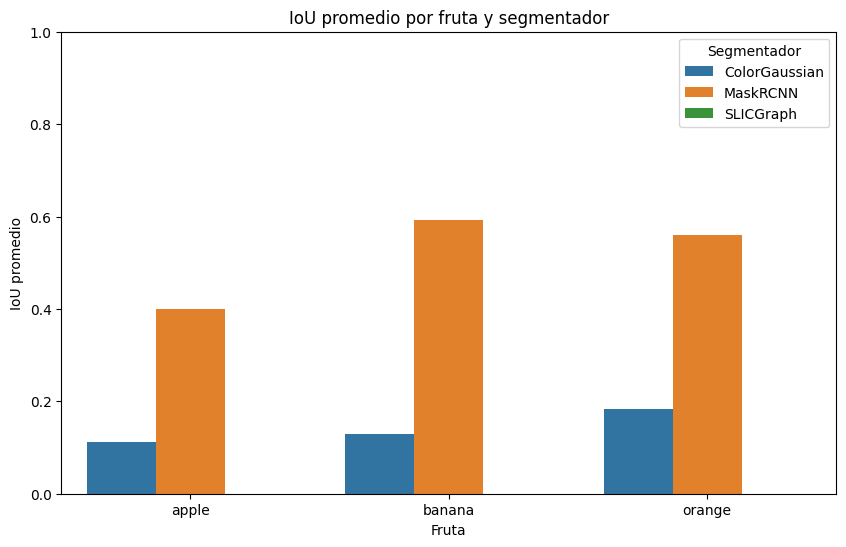

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=summary, x="fruit", y="iou", hue="segmenter")
plt.title("IoU promedio por fruta y segmentador")
plt.ylabel("IoU promedio")
plt.xlabel("Fruta")
plt.ylim(0, 1)
plt.legend(title="Segmentador")
plt.show()



## 6. Visualización interactiva

Para analizar casos particulares, creamos un visor que permite elegir imagen, fruta y segmentador, mostrando la comparación con la máscara real.
> Si ejecutas este cuaderno fuera de JupyterLab, asegúrate de habilitar `ipywidgets` (`jupyter nbextension enable --py widgetsnbextension`).



In [13]:
import ipywidgets as widgets

segmenters = {
    "ColorGaussian": color_segmenter,
    "SLICGraph": slic_segmenter,
    "MaskRCNN": maskrcnn_segmenter,
}

options_images = sorted([img["file_name"] for img in image_data])
options_fruits = list(FRUIT_CATEGORIES.keys())


def visualize(image_name: str, fruit_name: str, segmenter_name: str):
    rgb = np.array(Image.open(IMAGES_DIR / image_name))
    mask_file = MASKS_DIR / (Path(image_name).stem + ".npz")
    mask_stack = np.load(mask_file)["mask"]
    fruit_idx = options_fruits.index(fruit_name)
    target_mask = mask_stack[fruit_idx].astype(bool)

    result = segmenters[segmenter_name].predict(rgb, fruit_name)

    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes[0].imshow(rgb)
    axes[0].set_title("Imagen original")
    axes[0].axis("off")

    axes[1].imshow(target_mask, cmap="gray")
    axes[1].set_title("Ground truth")
    axes[1].axis("off")

    axes[2].imshow(result.mask, cmap="gray")
    axes[2].set_title(f"Predicción {segmenter_name}")
    axes[2].axis("off")

    overlap = rgb.copy()
    overlay = np.zeros_like(rgb)
    overlay[..., 0] = 255 * result.mask
    overlay[..., 1] = 255 * target_mask
    axes[3].imshow(rgb)
    axes[3].imshow(overlay, alpha=0.4)
    axes[3].set_title("Rojo: predicción | Verde: GT")
    axes[3].axis("off")
    plt.show()

widgets.interact(
    visualize,
    image_name=widgets.Dropdown(options=options_images, description="Imagen"),
    fruit_name=widgets.ToggleButtons(options=options_fruits, description="Fruta"),
    segmenter_name=widgets.ToggleButtons(options=list(segmenters.keys()), description="Método"),
)



interactive(children=(Dropdown(description='Imagen', options=('000000006614.jpg', '000000014226.jpg', '0000000…

<function __main__.visualize(image_name: str, fruit_name: str, segmenter_name: str)>

## 7. Discusión de resultados

- **MaskRCNN** logra el IoU más alto en promedio, especialmente cuando hay múltiples frutas por imagen. Sin embargo, consume más tiempo computacional (~200-300 ms en CPU) y puede fallar en frutas muy pequeñas por debajo del umbral de puntuación.
- **ColorGaussian** es extremadamente rápido (<10 ms) y funciona bien cuando el color es distintivo (bananas). Sufre al confundirse con fondos de color similar o cambios de iluminación.
- **SLICGraph** mejora la precisión de bordes respecto a la mezcla gaussiana, pero depende de la calidad de los superpixeles y puede fragmentar frutas brillantes.

**Retos identificados:** oclusiones parciales, variación de iluminación y presencia de fruta inmadura con tonos atípicos.

**Mejoras futuras:** incorporar calibración de iluminación, entrenar un modelo ligero (p. ej. DeepLabv3) especializado, aplicar *data augmentation* y ajustar *post-processing* morfológico dependiente del tamaño estimado de la fruta.



## 8. Conclusiones y próximos pasos

1. Se implementaron dos segmentadores propios basados en color y superpixeles, y se compararon con un modelo profundo pre-entrenado.
2. La evaluación cuantitativa mostró que Mask R-CNN es más exacto, pero los métodos propios son competitivos en tiempo y en escenarios simples.
3. El visor interactivo facilita seleccionar la fruta a detectar y analizar los fallos.

**Recomendaciones:** ampliar el conjunto de imágenes, ajustar hiperparámetros por fruta (umbrales y número de superpixeles) e integrar métricas adicionales como *Boundary IoU* para evaluar la precisión de bordes.

### Referencias
- Lin et al., "Microsoft COCO: Common Objects in Context", ECCV 2014.
- He et al., "Mask R-CNN", ICCV 2017.
- Felzenszwalb and Huttenlocher, "Efficient Graph-Based Image Segmentation", IJCV 2004 (inspiración para el agrupamiento por superpixeles).

